### A visual inspection of Regional Economic Trends: North America & Latin America 

#### Introduction

- Renewable Energy Adoption
    - Renewable energy consumption 
- Climate Mitigation Efforts
    - CO2, Methane, NO emissions
    - Greenhouse gas emissions 
- Environmental Impact
    - Fossil fuel energy consumption
    - Forest area (% of land area)

In [4]:
import pandas as pd
import sqlite3

In [5]:
def read_sqlite_table(db_path, table_name=None, query=None):
    conn = sqlite3.connect(db_path)
    
    if query:
        df = pd.read_sql_query(query, conn)
    elif table_name:
        df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    else:
        raise ValueError("Either table_name or query must be provided")
    
    conn.close()
    return df

In [6]:
lcn_df = read_sqlite_table("../data/world_data.sqlite", table_name="LCN")
lcn_df.to_csv("../data/lcn.csv", index=False)
nac_df = read_sqlite_table("../data/world_data.sqlite", table_name="NAC")
nac_df.to_csv("../data/nac.csv", index=False)

In [7]:
# Overview Metrics
overview_codes = [
    'EN.GHG.ALL.PC.CE.AR5',  # Per capita emissions
    'EG.USE.ELEC.KH.PC',     # Electricity consumption per capita
    'EG.IMP.CONS.ZS'         # Energy imports
]


# Emissions Analysis
emissions_analysis = {
    'total_ghg': ['EN.GHG.TOT.ZG.AR5'],
    'co2': [
        'EN.GHG.CO2.MT.CE.AR5',
        'EN.GHG.CO2.ZG.AR5',
        'EN.GHG.CO2.RT.GDP.KD',
        'EN.GHG.CO2.RT.GDP.PP.KD'
    ],
    'methane': [
        'EN.GHG.CH4.TR.MT.CE.AR5',
        'EN.GHG.CH4.IC.MT.CE.AR5',
        'EN.GHG.CH4.WA.MT.CE.AR5'
    ],
    'n2o': [
        'EN.GHG.N2O.TR.MT.CE.AR5',
        'EN.GHG.N2O.IC.MT.CE.AR5',
        'EN.GHG.N2O.PI.MT.CE.AR5',
        'EN.GHG.N2O.FE.MT.CE.AR5'
    ]
}

# Energy Production & Consumption
energy_analysis = {
    'renewable': [
        'EG.FEC.RNEW.ZS',
        'EG.ELC.RNWX.ZS',
        'EG.ELC.RNWX.KH',
        'EG.ELC.HYRO.ZS'
    ],
    'fossil_fuels': [
        'EG.ELC.FOSL.ZS',
        'EG.ELC.COAL.ZS',
        'EG.ELC.NGAS.ZS',
        'EG.ELC.PETR.ZS'
    ],
    'nuclear': ['EG.ELC.NUCL.ZS']
}

In [8]:
# Overview DataFrames
overview_lcn = lcn_df[lcn_df['IndicatorCode'].isin(overview_codes)].drop_duplicates()
overview_nac = nac_df[nac_df['IndicatorCode'].isin(overview_codes)].drop_duplicates()

# Emissions DataFrames
emissions_lcn = {
   'total': lcn_df[lcn_df['IndicatorCode'].isin(emissions_analysis['total_ghg'])],
   'co2': lcn_df[lcn_df['IndicatorCode'].isin(emissions_analysis['co2'])],
   'methane': lcn_df[lcn_df['IndicatorCode'].isin(emissions_analysis['methane'])],
   'n2o': lcn_df[lcn_df['IndicatorCode'].isin(emissions_analysis['n2o'])]
}

emissions_nac = {
   'total': nac_df[nac_df['IndicatorCode'].isin(emissions_analysis['total_ghg'])],
   'co2': nac_df[nac_df['IndicatorCode'].isin(emissions_analysis['co2'])],
   'methane': nac_df[nac_df['IndicatorCode'].isin(emissions_analysis['methane'])],
   'n2o': nac_df[nac_df['IndicatorCode'].isin(emissions_analysis['n2o'])]
}

# Energy DataFrames
energy_lcn = {
   'renewable': lcn_df[lcn_df['IndicatorCode'].isin(energy_analysis['renewable'])],
   'fossil': lcn_df[lcn_df['IndicatorCode'].isin(energy_analysis['fossil_fuels'])],
   'nuclear': lcn_df[lcn_df['IndicatorCode'].isin(energy_analysis['nuclear'])]
}

energy_nac = {
   'renewable': nac_df[nac_df['IndicatorCode'].isin(energy_analysis['renewable'])],
   'fossil': nac_df[nac_df['IndicatorCode'].isin(energy_analysis['fossil_fuels'])],
   'nuclear': nac_df[nac_df['IndicatorCode'].isin(energy_analysis['nuclear'])]
}

In [9]:
def write_source_notes(data, filename="../data/source_notes.txt"):
    """Write source notes for each indicator to a file."""
    with open(filename, "w", encoding="utf-8") as f:
        f.write("Source Notes for Indicators\n")
        f.write("==========================\n\n")
        for idx, row in data.iterrows():
            f.write(f"Indicator Code: {row['IndicatorCode']}\n")
            f.write(f"Indicator Name: {row['IndicatorName']}\n")
            f.write(f"Source Note: {row['SourceNote']}\n")
            f.write("-" * 80 + "\n\n")

### Plottings

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from itertools import islice


def preprocess_emissions_data(emissions_dict):
    """
    Remove duplicates from emissions DataFrames.

    Args:
        emissions_dict (dict): Dictionary containing emissions DataFrames

    Returns:
        dict: Dictionary with cleaned DataFrames
    """
    cleaned_dict = {}
    for key, df in emissions_dict.items():
        # Drop duplicates based on all columns
        cleaned_df = df.drop_duplicates()
        # Also drop duplicates based on IndicatorCode and year columns
        year_cols = [col for col in df.columns if str(col).isdigit()]
        subset_cols = ["IndicatorCode"] + year_cols
        cleaned_df = cleaned_df.drop_duplicates(subset=subset_cols)
        cleaned_dict[key] = cleaned_df
    return cleaned_dict


def plot_emissions_comparison(
    emissions_lcn: dict,
    emissions_nac: dict,
    plot_title: str,
    output_path: str,
    figsize: tuple = (14, 10),
    num_col_graphs: int = 2,
    row_spacing: float = 0.3,
    col_spacing: float = 0.3,
):
    """
    Plot emissions data comparing LCN and NAC datasets.

    Args:
        emissions_lcn (dict): Dictionary containing LCN emissions DataFrames
        emissions_nac (dict): Dictionary containing NAC emissions DataFrames
        figsize (tuple): Figure size in inches
        num_col_graphs (int): Number of columns in the subplot grid
        row_spacing (float): Spacing between rows
        col_spacing (float): Spacing between columns
    """
    # Clean data first
    emissions_lcn_clean = preprocess_emissions_data(emissions_lcn)
    emissions_nac_clean = preprocess_emissions_data(emissions_nac)

    # Calculate number of rows needed
    num_row_graphs = math.ceil(len(emissions_lcn_clean) / num_col_graphs)

    # Create subplot grid with tighter layout
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(
        num_row_graphs, num_col_graphs, hspace=row_spacing, wspace=col_spacing
    )
    axes = [
        fig.add_subplot(gs[i // num_col_graphs, i % num_col_graphs])
        for i in range(num_row_graphs * num_col_graphs)
    ]

    # Create color palettes for both datasets
    lcn_palette = sns.color_palette("husl", len(emissions_lcn_clean))
    nac_palette = sns.color_palette("Set2", len(emissions_nac_clean))

    # Plot each type of emission
    for idx, (emission_type, lcn_df) in enumerate(emissions_lcn_clean.items()):
        write_source_notes(lcn_df, f'{emission_type}_source_notes.txt')
        nac_df = emissions_nac_clean[emission_type]

        # Get numeric columns (years)
        year_cols = [col for col in lcn_df.columns if str(col).isdigit()]
        x_values = [int(year) for year in year_cols]

        # Plot LCN data
        for i, row in lcn_df.iterrows():
            indicator_name = row["IndicatorName"]
            y_values = row[year_cols].astype(float)

            axes[idx].plot(
                x_values,
                y_values,
                "_-",
                linewidth=1.5,
                color=lcn_palette[i % len(lcn_palette)],
                label=f'LCN - {row["IndicatorCode"]}',
            )

        # Plot NAC data
        for i, row in nac_df.iterrows():
            y_values = row[year_cols].astype(float)

            axes[idx].plot(
                x_values,
                y_values,
                "--",
                linewidth=1.5,
                color=nac_palette[i % len(nac_palette)],
                label=f'NAC - {row["IndicatorCode"]}',
            )

        # Customize plot with minimal padding
        axes[idx].set_title(
            f"{emission_type.upper()} {plot_title} ", fontsize=12, pad=3
        )  # Reduced padding between title and plot
        axes[idx].set_xlabel("Year", fontsize=12)
        axes[idx].set_ylabel(f"{plot_title.split()[0]}", fontsize=12)
        axes[idx].grid(True, which="both", linestyle="--", linewidth=0.3)
        axes[idx].tick_params(axis="both", labelsize=8)
        axes[idx].legend(loc="best", fontsize=6)

    # Hide unused axes
    for j in range(len(emissions_lcn_clean), len(axes)):
        axes[j].axis("off")

    fig.suptitle(
        f"{plot_title}: Latin America & Caribbean vs North America",
        fontsize=14,
        fontweight="bold",
        y=0.95,
    )
    plt.tight_layout()
    plt.savefig(output_path, format="pdf", bbox_inches="tight", pad_inches=0.5)
    plt.show()

### Overview 

In [50]:
def plot_overview_comparison(
    overview_lcn: pd.DataFrame,
    overview_nac: pd.DataFrame,
    output_path: str,
    figsize: tuple = (12, 8),
    row_spacing: float = 0.4,
    col_spacing: float = 0.3,
):
    """
    Plot overview data comparing LCN and NAC datasets.

    Args:
        overview_lcn (pd.DataFrame): DataFrame containing LCN overview data
        overview_nac (pd.DataFrame): DataFrame containing NAC overview data
        figsize (tuple): Figure size in inches
        row_spacing (float): Spacing between rows
        col_spacing (float): Spacing between columns
    """
    write_source_notes(overview_lcn, 'overview_source_notes.txt')
    # Create figure
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(1, 1, hspace=row_spacing, wspace=col_spacing)
    ax = fig.add_subplot(gs[0])

    # Get year columns
    year_cols = [col for col in overview_lcn.columns if str(col).isdigit()]
    x_values = [int(year) for year in year_cols]

    # Create color palettes
    lcn_palette = sns.color_palette("husl", len(overview_lcn))
    nac_palette = sns.color_palette("Set2", len(overview_nac))

    # Plot LCN data
    for i, row in overview_lcn.iterrows():
        y_values = row[year_cols].astype(float)
        ax.plot(
            x_values,
            y_values,
            "_-",
            linewidth=1.5,
            color=lcn_palette[i % len(lcn_palette)],
            label=f'LCN - {row["IndicatorName"]}',
        )

    # Plot NAC data
    for i, row in overview_nac.iterrows():
        y_values = row[year_cols].astype(float)
        ax.plot(
            x_values,
            y_values,
            "--",
            linewidth=1.5,
            color=nac_palette[i % len(nac_palette)],
            label=f'NAC - {row["IndicatorName"]}',
        )

    # Customize plot
    ax.set_title("Overview Metrics Comparison: Latin America & Caribbean vs North America", fontsize=14, pad=5)
    ax.set_xlabel("Year", fontsize=16)
    ax.set_ylabel("Value", fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.tick_params(axis="both", labelsize=10)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)

    
    # Save plot as PDF
    plt.savefig(output_path, format='pdf', bbox_inches='tight', pad_inches=0.1)
    # plt.savefig("overview_comparison.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

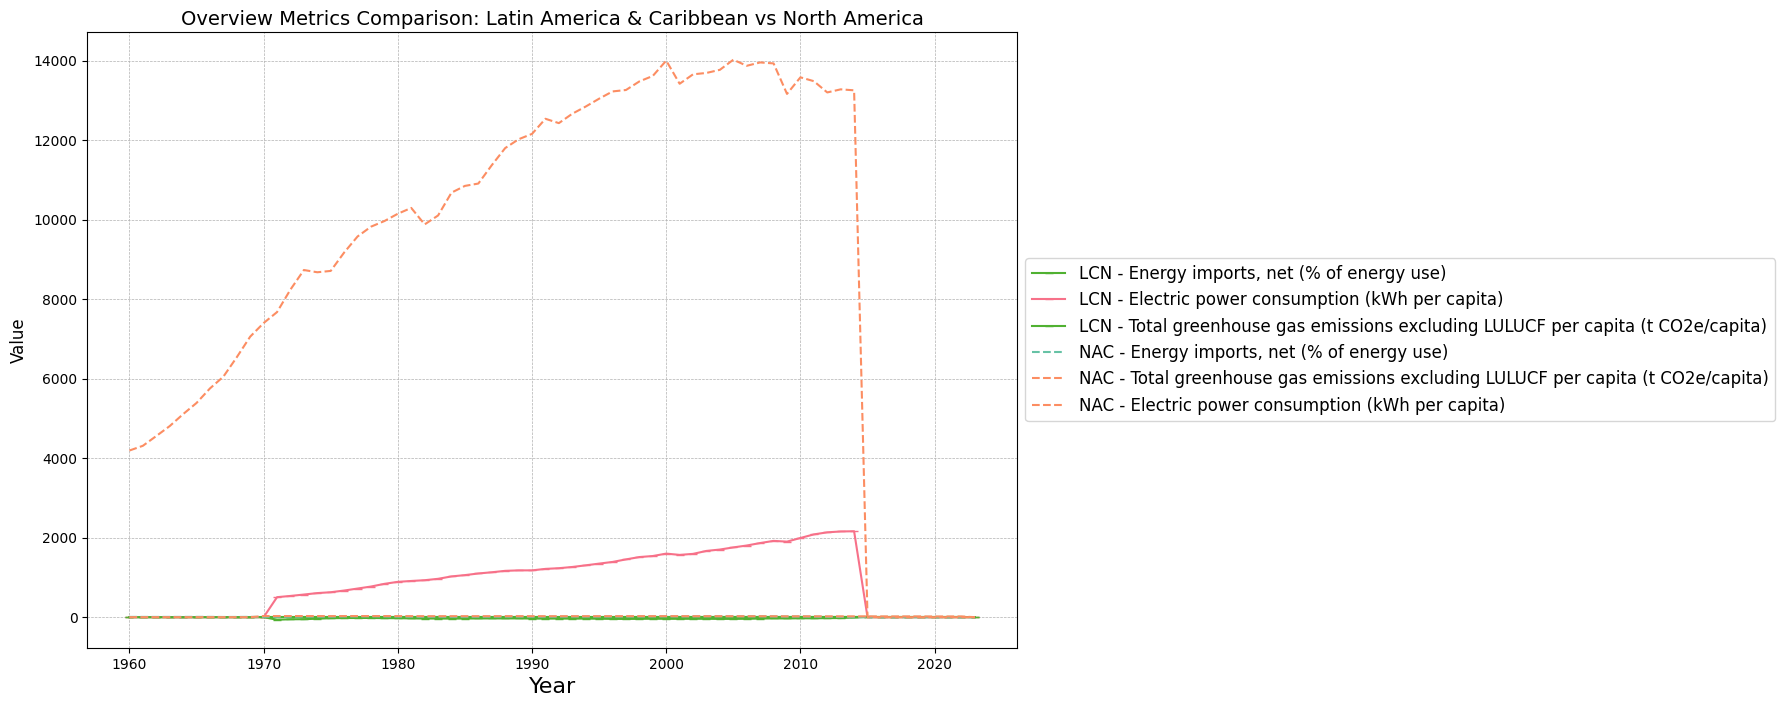

In [ ]:
# Plot overview comparison
plot_overview_comparison(overview_lcn, overview_nac, output_path="../data/overview_comparison.pdf")

### Emission Analysis

In [52]:
import pandas as pd

def save_unique_indicators_to_csv(data_dict, output_file):
    # Combine all DataFrames in the dictionary into a single DataFrame
    combined_df = pd.concat(data_dict.values(), ignore_index=True)

    # Extract unique IndicatorCode and IndicatorName pairs
    unique_indicators = combined_df[['IndicatorCode', 'IndicatorName', 'SourceNote']].drop_duplicates()

    # Save the unique pairs to a CSV file
    unique_indicators.to_csv(output_file, index=False)
    print(f"Unique indicators saved to {output_file}")

save_unique_indicators_to_csv(emissions_lcn, "../data/emissions_lcn.csv")
save_unique_indicators_to_csv(emissions_nac, "../data/emissions_nac.csv")
save_unique_indicators_to_csv(energy_lcn, "../data/energy_lcn.csv")
save_unique_indicators_to_csv(energy_nac, "../data/energy_nac.csv")

Unique indicators saved to ../data/emissions_lcn.csv
Unique indicators saved to ../data/emissions_nac.csv
Unique indicators saved to ../data/energy_lcn.csv
Unique indicators saved to ../data/energy_nac.csv


/tmp/ipykernel_21985/1297014419.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


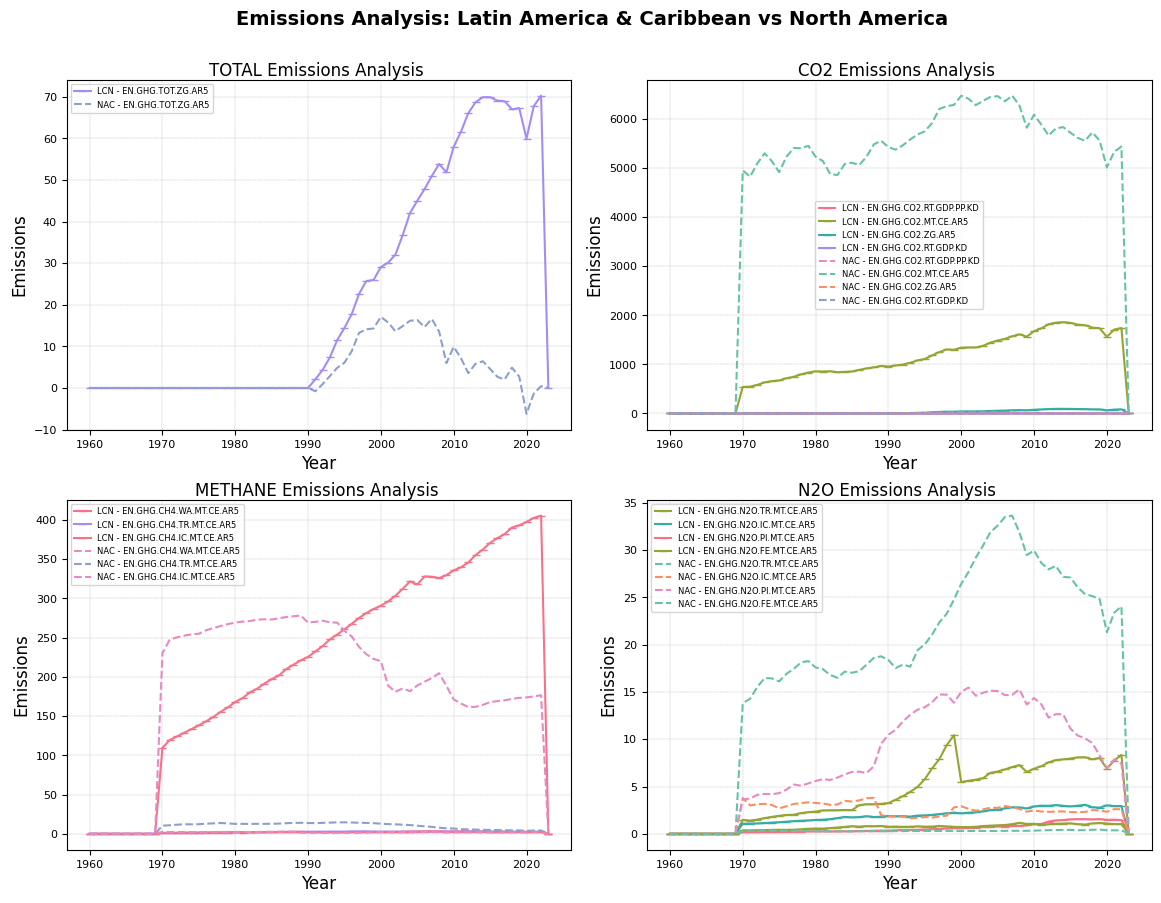

In [47]:
plot_emissions_comparison(
    emissions_lcn,
    emissions_nac,
    plot_title="Emissions Analysis",
    row_spacing=0.2,
    col_spacing=0.15,
    output_path="../data/emissions_comparison.pdf",
)

### Energy Analysis

/tmp/ipykernel_21985/1297014419.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


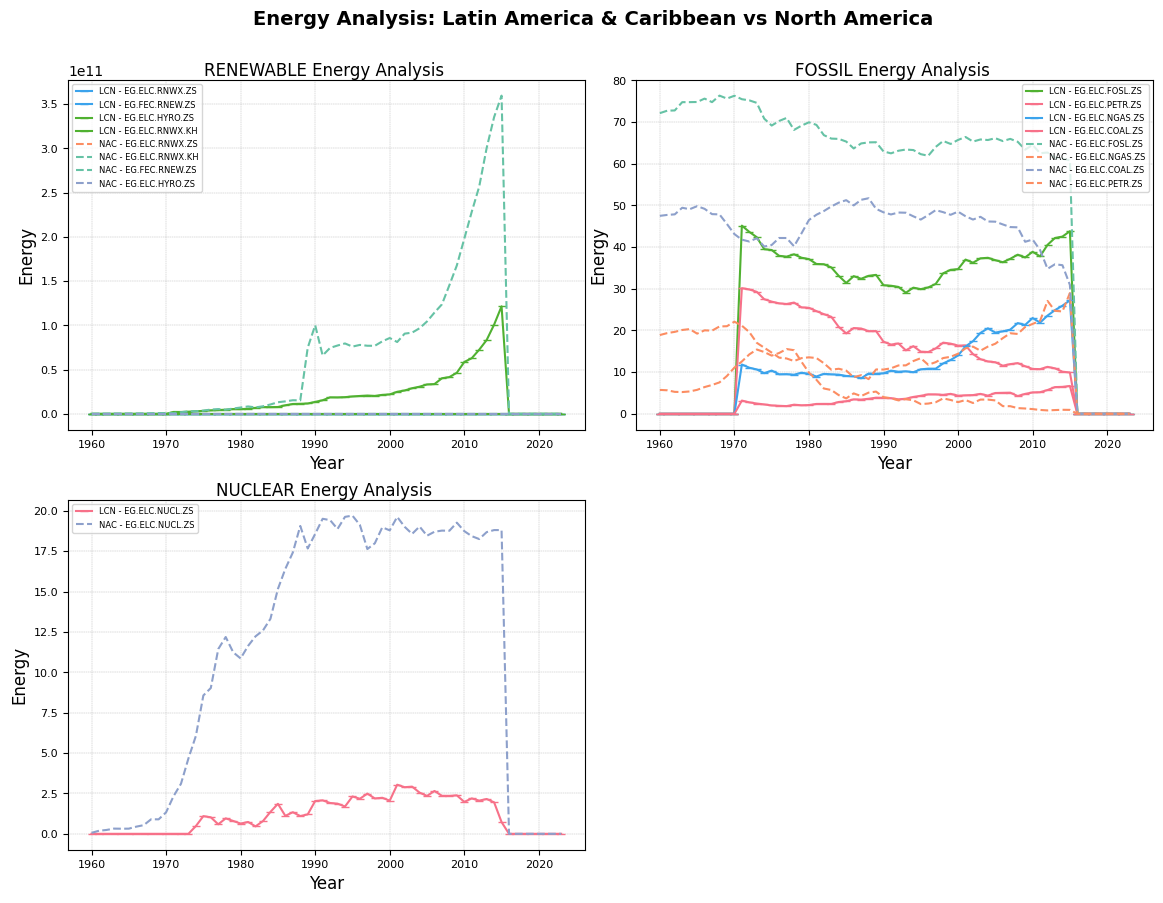

In [ ]:
plot_emissions_comparison(
    energy_lcn,
    energy_nac,
    plot_title="Energy Analysis",
    row_spacing=0.2,
    col_spacing=0.1,
    output_path="../data/energy_comparison.pdf",
)